# Policy Evaluation using Linear Models

In [1]:
%matplotlib notebook
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import tabulate
import numpy as np
import pandas as pd

In [2]:
import gym
from envs import MDP
from policies import Policy, UniformPolicy, RandomPolicy

In [3]:
env = gym.make('ThreeState-v0')
policy = RandomPolicy(env.n_nstates, env.action_space.n)

## Error functions

In [4]:
from algorithms.error_functions import mean_squared_value_error
from algorithms.error_functions import bellman_error
from algorithms.error_functions import td_error

msve = mean_squared_value_error(env, policy)
be = bellman_error(env, policy)
tde = td_error(env, policy)

## The true value function

In [5]:
from algorithms.closed_form import cf_policy_eval

v_pi = cf_policy_eval(env, policy)

print("Values: ", v_pi)
print(f"\nMSVE:           {msve(v_pi):.5f}")
print(f"Bellman Error:  {be(v_pi):.5f}")
print(f"TD Error:       {tde(v_pi):.5f}")

Values:  [-0.68023256 -0.36046512  1.04651163]

MSVE:           0.00000
Bellman Error:  0.00000
TD Error:       1.58285


## Approximation using linear models
$$v(s,{\bf w}) = x(s)^\intercal {\bf w}$$

In [6]:
assert env.n_states == 5 and env.n_nstates == 3

a, b = 1, 1
features = np.array([[1, 0], [0, 1], [a, b]], dtype=np.float)

### Minimizing MSVE, Bellman Error, and TD Error

In [7]:
from algorithms.closed_form import cf_minimum_msve
from algorithms.closed_form import cf_minimum_tderror
from algorithms.closed_form import cf_minimum_bellman

table = [["Values", "MSV Error", "Bellman Error", "TD Error"]]
error_fns = [msve, be, tde]

table.append(["v_pi"] + [np.round(x, decimals=7) for x in [err(v_pi) for err in error_fns]])

# -- Tabular

v_msve_tab = cf_minimum_msve(env, policy)
table.append(["min MSVE [T]"] + [np.round(x, decimals=7) for x in [err(v_msve_tab) for err in error_fns]])

v_be_tab = cf_minimum_bellman(env, policy)
table.append(["min Bellman [T]"] + [np.round(x, decimals=7) for x in [err(v_be_tab) for err in error_fns]])

v_td_tab = cf_minimum_tderror(env, policy)
table.append(["min TDerr [T]"] + [np.round(x, decimals=7) for x in [err(v_td_tab) for err in error_fns]])

# -- Function approximation

w_msve = cf_minimum_msve(env, policy, features)
v_msve = features @ w_msve
table.append(["min MSVE(w)"] + [np.round(x, decimals=7) for x in [err(v_msve) for err in error_fns]])

w_be = cf_minimum_bellman(env, policy, features)
v_be = features @ w_be
table.append(["min Bellman(w)"] + [np.round(x, decimals=7) for x in [err(v_be) for err in error_fns]])

w_td = cf_minimum_tderror(env, policy, features)
v_td = features @ w_td
table.append(["min TDerr(w)"] + [np.round(x, decimals=7) for x in [err(v_td) for err in error_fns]])

print(tabulate.tabulate(table, headers="firstrow"))

Values             MSV Error    Bellman Error    TD Error
---------------  -----------  ---------------  ----------
v_pi                0               0             1.58285
min MSVE [T]        0               0             1.58285
min Bellman [T]     0               0             1.58285
min TDerr [T]       0.128171        0.0491583     1.46461
min MSVE(w)         0.273474        0.336611      1.81658
min Bellman(w)      0.43657         0.260458      1.85494
min TDerr(w)        0.31782         0.305187      1.72926


## Policy evalution using DP

<IPython.core.display.Javascript object>


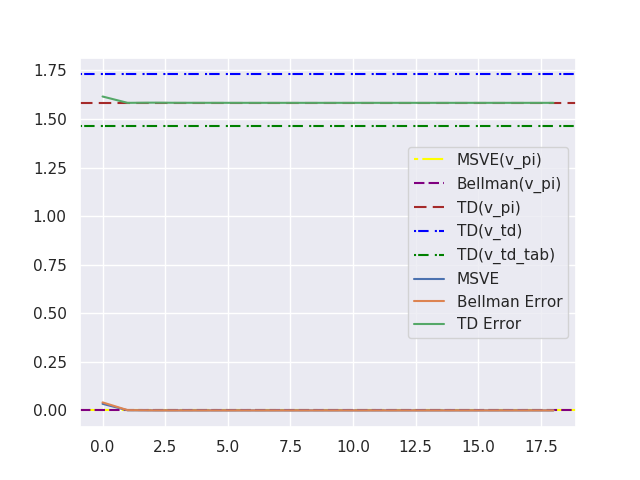

In [8]:
from algorithms.dynamic_programming import dp_policy_eval

trace = dp_policy_eval(env, policy, keeptrace=True)
msve_trace = [msve(vals) for vals in trace]
be_trace = [be(vals) for vals in trace]
tde_trace = [tde(vals) for vals in trace]
x = np.arange(len(msve_trace))

plt.figure()

plt.axhline(msve(v_pi), color="yellow", dashes=[2, 2, 10, 2], label="MSVE(v_pi)")
plt.axhline(be(v_pi), color="purple", dashes=[5, 2], label="Bellman(v_pi)")

plt.axhline(tde(v_pi), color="brown", dashes=[6, 3], label="TD(v_pi)")
plt.axhline(tde(v_td), color="blue", dashes=[1, 1, 5, 3], label="TD(v_td)")
plt.axhline(tde(v_td_tab), color="green", dashes=[1, 1, 5, 3], label="TD(v_td_tab)")

plt.plot(x, msve_trace, label="MSVE")
plt.plot(x, be_trace, label="Bellman Error")
plt.plot(x, tde_trace, label="TD Error")
plt.legend();

## Gradient Monte Carlo

<IPython.core.display.Javascript object>


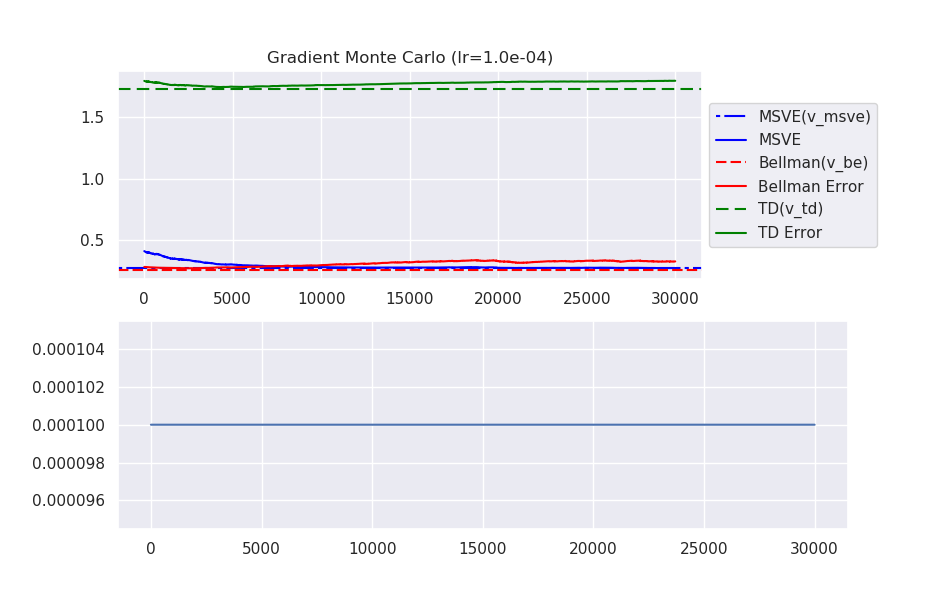

In [10]:
from algorithms.online_algorithms import GradientMonteCarlo
episodes_no = 30000
lr = {"name": "const", "value": 1e-4}

gmc = GradientMonteCarlo(env, policy, features, lr=lr)
results = gmc.train(episodes_no=episodes_no, step = 1)

plt.figure()
ax = plt.subplot(211)
plt.title(f"Gradient Monte Carlo (lr={str(gmc.lr):s})")
ax.axhline(msve(v_msve), color="blue", dashes=[2, 2, 10, 2], label="MSVE(v_msve)")
ax.plot(results["episode"], results["msve"], color="blue", label="MSVE")
ax.axhline(be(v_be), color="red", dashes=[5, 2], label="Bellman(v_be)")
ax.plot(results["episode"], results["berr"], color="red", label="Bellman Error")
ax.axhline(tde(v_td), color="green", dashes=[6, 3], label="TD(v_td)")
ax.plot(results["episode"], results["tderr"], color="green", label="TD Error")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

ax = plt.subplot(212)
ax.plot(results["episode"], results["lrs"])

<IPython.core.display.Javascript object>


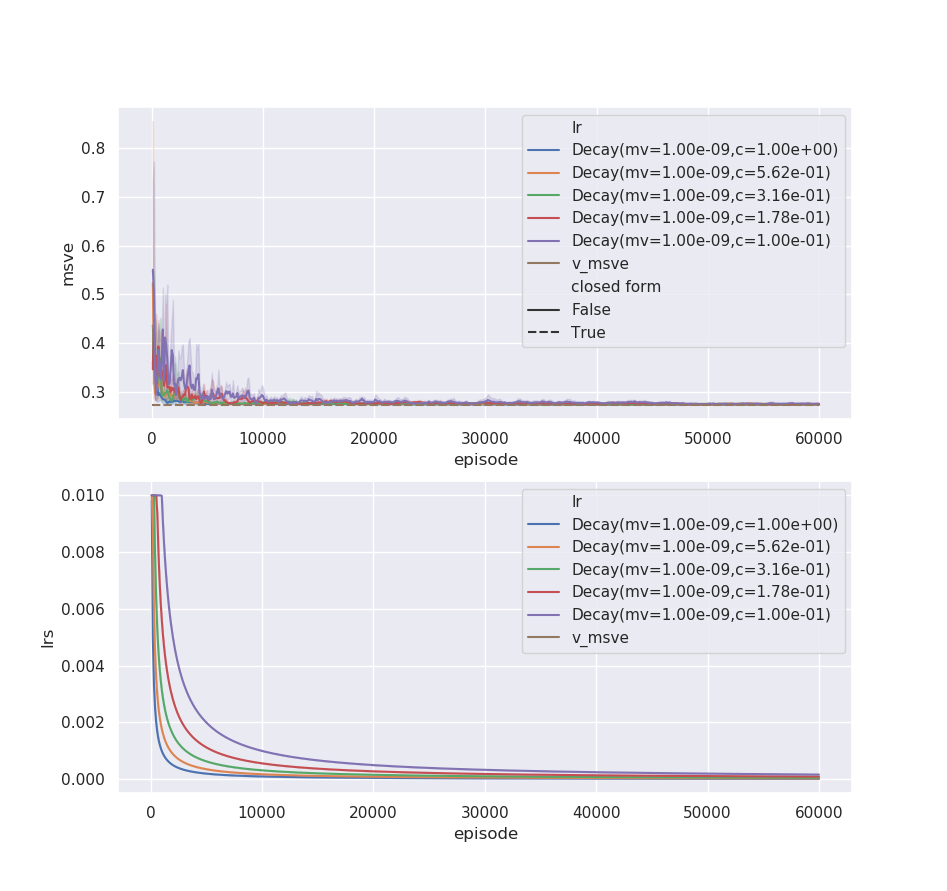

Process ForkPoolWorker-9:
Process ForkPoolWorker-11:
Process ForkPoolWorker-10:
Process ForkPoolWorker-14:
Process ForkPoolWorker-13:
Process ForkPoolWorker-12:
Process ForkPoolWorker-15:
Process ForkPoolWorker-8:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/tudor/anaconda3/envs/sandra_romain/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tudor/anaconda3/envs/sandra_romain/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tudor/anaconda3/envs/sandra_romain/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/tudor/anaconda3/envs/sandra_romain/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/tud

In [12]:
from algorithms.online_algorithms import GradientMonteCarlo
import multiprocessing as mp
import itertools

def train(lrargs, episodes_no, step, run_id):
    env = gym.make('ThreeState-v0')
    gmc = GradientMonteCarlo(env, policy, features, lr=lrargs)
    results = gmc.train(episodes_no=episodes_no, step=step)
    data = pd.DataFrame({key: results[key]
                         for key in ["episode", "msve", "berr", "tderr", "err", "lrs"]})
    data["lr"] = gmc.lr.__str__(precision=2)
    data["closed form"] = False
    data["run_id"] = run_id
    return data

pool = mp.Pool(8)
episodes_no = 30000
cs = np.logspace(-1, 0, num=5)[::-1]
lrs = [{"name": "decay", "c": c, "max_value": .01} for (c, m) in itertools.product(cs, min_values)]
step = 100
async_results = [pool.apply_async(train, (lr, episodes_no, step, run_id)) for lr in lrs for run_id in range(9)]
dfs = [async_result.get() for async_result in async_results]

w_msve = cf_minimum_msve(env, policy, features)
v_msve = features @ w_msve
data_msve = pd.DataFrame({"episode": np.array([1, episodes_no])})
data_msve["lr"] = "v_msve"
data_msve["msve"] = msve(v_msve)
data_msve["berr"] = be(v_msve)
data_msve["tderr"] = tde(v_msve)
data_msve["err"] = -1
data_msve["closed form"] = True
data_msve["run_id"] = 1
dfs.append(data_msve)

data = pd.concat(dfs, sort=False)

plt.figure()
ax = plt.subplot(211)
ax = sns.lineplot(data=data, x="episode", y="msve", hue="lr", style="closed form", ax=ax);

ax = plt.subplot(212)
ax = sns.lineplot(data=data, x="episode", y="lrs", hue="lr", ax=ax);

<IPython.core.display.Javascript object>


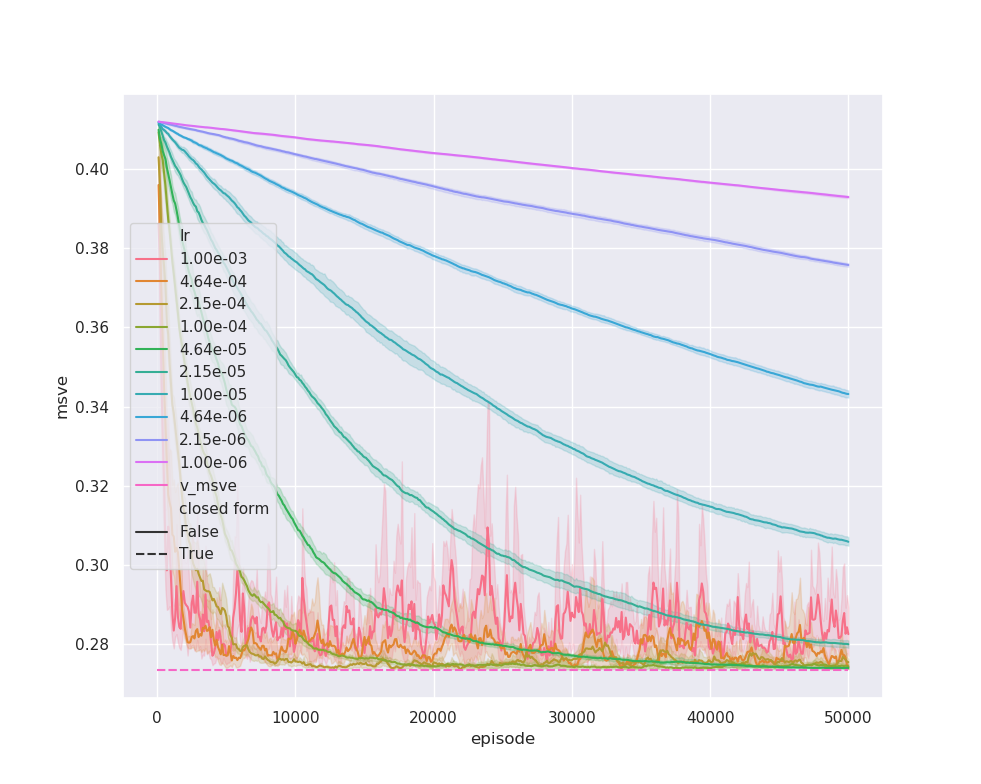

In [14]:
from algorithms.online_algorithms import GradientMonteCarlo
import multiprocessing as mp
import itertools

def train(lrargs, episodes_no, step, run_id):
    env = gym.make('ThreeState-v0')
    gmc = GradientMonteCarlo(env, policy, features, lr=lrargs)
    results = gmc.train(episodes_no=episodes_no, step=step)
    data = pd.DataFrame({key: results[key]
                         for key in ["episode", "msve", "berr", "tderr", "err"]})
    data["lr"] = gmc.lr.__str__(precision=2)
    data["closed form"] = False
    data["run_id"] = run_id
    return data

pool = mp.Pool(8)
episodes_no = 50000
lrs = [{"name": "const", "value": value} for value in np.logspace(-3, -6, 10)]
step = 100
async_results = [pool.apply_async(train, (lr, episodes_no, step, run_id)) for lr in lrs for run_id in range(9)]
dfs = [async_result.get() for async_result in async_results]

w_msve = cf_minimum_msve(env, policy, features)
v_msve = features @ w_msve
data_msve = pd.DataFrame({"episode": np.array([1, episodes_no])})
data_msve["lr"] = "v_msve"
data_msve["msve"] = msve(v_msve)
data_msve["berr"] = be(v_msve)
data_msve["tderr"] = tde(v_msve)
data_msve["err"] = -1
data_msve["closed form"] = True
data_msve["run_id"] = 1
dfs.append(data_msve)

data = pd.concat(dfs, sort=False)

plt.figure()
ax = sns.lineplot(data=data, x="episode", y="msve", hue="lr", style="closed form", );

## Gradient TD(n)

1.0e-04


<IPython.core.display.Javascript object>


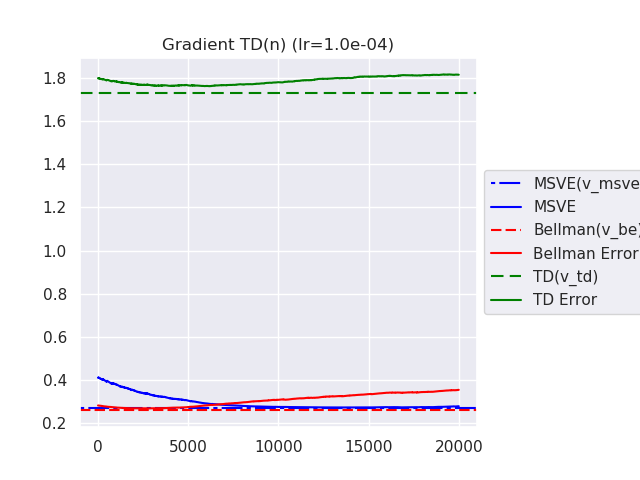

In [12]:
from algorithms.online_algorithms import GradientTDn
LR = {"name": 1e-4}
N = 2
SEMIGRADIENT = False

gtd = GradientTDn(env, policy, features,
                  lr=LR, n = N, semigradient=SEMIGRADIENT)
results = gtd.train(episodes_no=20000)
x = np.arange(len(results["msve"]))

plt.figure()
ax = plt.subplot(111)
plt.title(f"Gradient TD(n) (lr={str(gtd.lr)})")
ax.axhline(msve(v_msve), color="blue", dashes=[2, 2, 10, 2], label="MSVE(v_msve)")
ax.plot(x, results["msve"], color="blue", label="MSVE")
ax.axhline(be(v_be), color="red", dashes=[5, 2], label="Bellman(v_be)")
ax.plot(x, results["berr"], color="red", label="Bellman Error")
ax.axhline(tde(v_td), color="green", dashes=[6, 3], label="TD(v_td)")
ax.plot(x, results["tderr"], color="green", label="TD Error")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

In [1]:
from algorithms.online_algorithms import GradientTDn
import multiprocessing as mp
import itertools

def train(lrargs, n, semigradient, episodes_no, step, run_id):
    env = gym.make('ThreeState-v0')
    gtd = GradientTDn(env, policy, features,
                             lr=lrargs, n=n, semigradient=semigradient)
    results = gtd.train(episodes_no=episodes_no, step=step)
    data = pd.DataFrame({key: results[key]
                         for key in ["episode", "msve", "berr", "tderr", "err"]})
    data["lr"] = gtd.lr.__str__(precision=2)
    data["closed form"] = False
    data["run_id"] = run_id
    return data


pool = mp.Pool(8)
episodes_no = 25000
lrs = [{"name": "const", "value": value} for value in np.logspace(-3, -6, 7)]
ns = [1, 3, 5]
semigradient = [True, False]

args = itertools.product(lrs, ns, semigradient)

step = 50
async_results = [pool.apply_async(train, (lr, n, sg, episodes_no, step, run_id))
                 for (lr, n, sg) in args for run_id in range(5)]
dfs = [async_result.get() for async_result in async_results]

w_msve = cf_minimum_msve(env, policy, features)
v_msve = features @ w_msve
data_msve = pd.DataFrame({"episode": np.array([1, episodes_no])})
data_msve["lr"] = "v_msve"
data_msve["msve"] = msve(v_msve)
data_msve["berr"] = be(v_msve)
data_msve["tderr"] = tde(v_msve)
data_msve["err"] = -1
data_msve["closed form"] = True
data_msve["run_id"] = 1
dfs.append(data_msve)

w_td = cf_minimum_tderror(env, policy, features)
v_td = features @ w_td
data_td = pd.DataFrame({"episode": np.array([1, episodes_no])})
data_td["lr"] = "v_td"
data_td["msve"] = msve(v_td)
data_td["berr"] = be(v_td)
data_td["tderr"] = tde(v_td)
data_td["err"] = -1
data_td["closed form"] = True
data_td["run_id"] = 1
dfs.append(data_td)

data = pd.concat(dfs, sort=False)

NameError: name 'np' is not defined

## LSTD

<IPython.core.display.Javascript object>


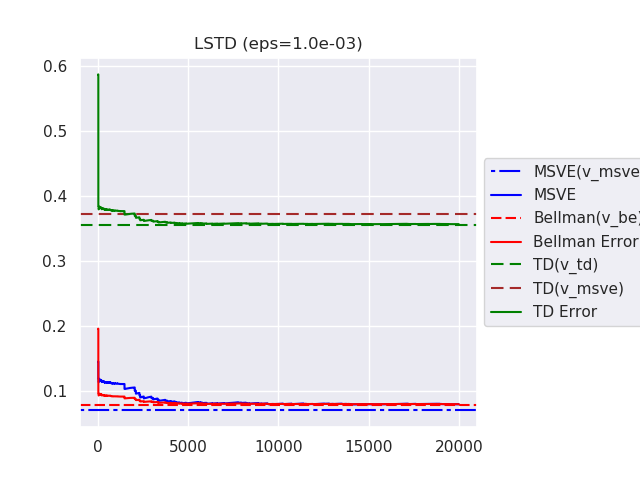

In [8]:
from algorithms.online_algorithms import LSTD
EPS = .001

lstd = LSTD(env, policy, features,
            eps=EPS)
results = lstd.train(episodes_no=20000, step=1)
x = np.arange(len(results["msve"]))

plt.figure()
ax = plt.subplot(111)
plt.title(f"LSTD (eps={EPS:.1e})")
ax.axhline(msve(v_msve), color="blue", dashes=[2, 2, 10, 2], label="MSVE(v_msve)")
ax.plot(x, results["msve"], color="blue", label="MSVE")
ax.axhline(be(v_be), color="red", dashes=[5, 2], label="Bellman(v_be)")
ax.plot(x, results["berr"], color="red", label="Bellman Error")
ax.axhline(tde(v_td), color="green", dashes=[6, 3], label="TD(v_td)")

ax.axhline(tde(v_msve), color="brown", dashes=[6, 3], label="TD(v_msve)")

ax.plot(x, results["tderr"], color="green", label="TD Error")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

In [37]:
lstd.b, np.linalg.inv(lstd.inv_a)

(array([-10991.,   -144.]), array([[27082.85, -6149.  ],
        [-3056.24,  9224.96]]))